In [1]:
import os
import json
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [2]:
class Config:
    """config class with contains data, train and model hyperparameters"""


    def __init__(self):
        pass
    
    def from_json(self,json_path):
        """creates config from json"""
        params = json.load(open(json_path))
        # add to params path pathlib style 
        for k, v in params.items():
            print(k, v)
            setattr(self, k, v)
        return self
    
setting_file = "configs/config_v2.json"
Cfg = Config().from_json(setting_file)
os.makedirs(Cfg.preprocess_dir, exist_ok=True)
    

IS_DEBUG True
train_path dataloader/datasets/data_raw//train_series.parquet
train_target_path dataloader/datasets/data_raw/train_events.csv
test_path dataloader/datasets/data_raw/test_series.parquet
sample_submission_path dataloader/datasets/data_raw/sample_submission.csv
preprocess_dir dataloader/datasets/v2/
weight_dir_1dcnn model/weights_v2/
weight_dir_lgbm model/lgbm_models_v2/
inputs_2nd dataloader/datasets/v2/df_second_model.feather
steps_per_sec 0.2
step_for_1min 12.0
step_for_15min 180.0
step_for_30min 360.0
step_for_a_day 17280.0


In [3]:
import pyarrow.parquet as pq

parquet_file = pq.read_table(Cfg.train_path)
df_train = parquet_file.to_pandas()

In [4]:
# df_train = pd.read_parquet(Cfg.train_path)
df_test = pd.read_parquet(Cfg.test_path)
sample_submission = pd.read_csv(Cfg.sample_submission_path)
df_target = pd.read_csv(Cfg.train_target_path)

0   2018-08-14 15:30:00-04:00
dtype: datetime64[ns, UTC-04:00]
0    11160.0
dtype: float64


C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_10988\1760346496.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['dayofweek'] = (offset.dt.dayofweek.values[0] + (first_train['step'] + offset_step.values[0]) // Cfg.step_for_a_day) % 7
C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_10988\1760346496.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['daily_step'] = (first_train['step'] + offset_step.values[0]) % Cfg.step_for_a_day
C:\Users\pawel.dubel\AppData\Local\Temp\ipyk

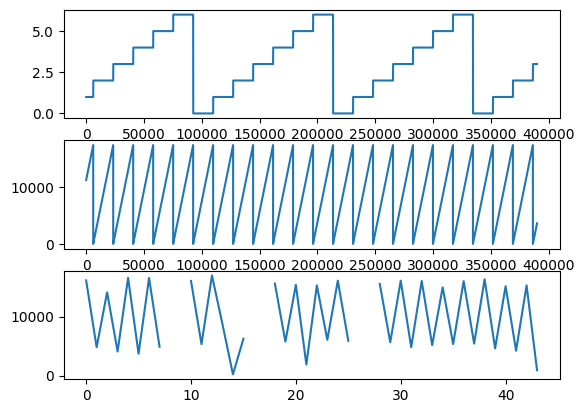

In [5]:

first_train = df_train[df_train["series_id"]==df_train.series_id[0]]
first_target = df_target[df_target["series_id"]==df_target.series_id[0]]

offset_date = df_train['timestamp'].iloc[0:1].str.split('T',expand=True)[0]
offset_time = df_train['timestamp'].iloc[0:1].str.split('T',expand=True)[1]
offset = pd.to_datetime(offset_date +" " + offset_time)
print(offset)
offset_step = (offset.dt.hour * 60 * 60 + offset.dt.minute * 60  + offset.dt.second) * Cfg.steps_per_sec
offset_step
print(offset_step)


first_train['dayofweek'] = (offset.dt.dayofweek.values[0] + (first_train['step'] + offset_step.values[0]) // Cfg.step_for_a_day) % 7
first_train['daily_step'] = (first_train['step'] + offset_step.values[0]) % Cfg.step_for_a_day
first_target['daily_step'] = (first_target['step'] + offset_step.values[0]) % Cfg.step_for_a_day

plt.subplot(3,1,1)
# plt.plot(((offset.dt.dayofweek.values[0] +  first_train['step'].astype(np.int32).map(lambda x : x+ int(offset_step.values[0]))// Cfg.step_for_a_day)) % 7)
plt.plot(first_train['dayofweek'])
plt.subplot(3,1,2)
plt.plot(first_train['daily_step'])
plt.subplot(3,1,3)
plt.plot(first_target['daily_step'])
plt.show()



C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_10988\2961861222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target'] = -1
C:\Users\pawel.dubel\AppData\Local\Temp\ipykernel_10988\2961861222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target_sw'] = 0


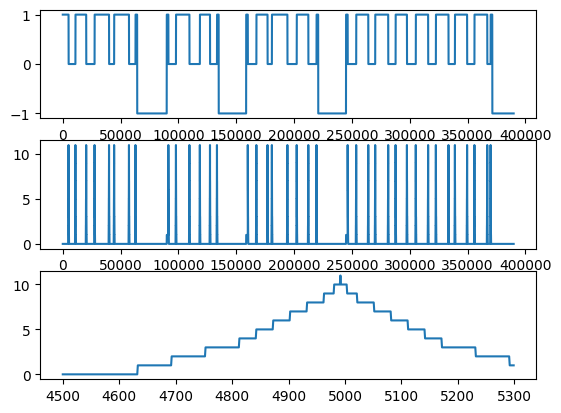

In [6]:
first_train['target'] = -1
first_train['target_sw'] = 0

sw_step_range = [i-1 for i in [1,12,30,60,90,120,150,180,240,300,360]][::-1]
sw_labels = [i for i in range(11,0,-1)][::-1]

last_state = -1
last_event_step = 0

valid_range_with_nan = int(Cfg.step_for_30min*4)
max_step = first_target['step'].values.max()

for step,event,night in first_target[["step","event","night"]].values:

    event_range = (first_train['step'] >= last_event_step) & (first_train['step'] <step)
    event_range_with_nan_before = (first_train['step'] >= np.maximum(step-valid_range_with_nan,0)) & (first_train['step'] <step)
    event_range_with_nan_after = (first_train['step'] < np.maximum(last_event_step+valid_range_with_nan,0)) & (first_train['step'] >= last_event_step)

    if np.isnan(step):
    
        first_train.loc[event_range_with_nan_after,'target'] = np.abs(last_event-1)
        last_state = -2
        continue

    if event =='onset' : 
        if last_state == 1 or last_state == -1:
            first_train.loc[event_range,'target'] = 1
        elif last_state == -2:
            first_train.loc[event_range_with_nan_before] = 1
        last_event = 1
        last_state = 0 
        last_event_step = step 
    
    elif event == 'wakeup':
        if last_state == 0 or last_state == -1:
            first_train.loc[event_range,'target'] = 0
        elif last_state == -2:
            first_train.loc[event_range_with_nan_before] = 0
        last_event = 0
        last_state = 1
        last_event_step = step 

    for label_range, sw_label in zip(sw_step_range, sw_labels):
        first_train.loc[(first_train['step'] >= (step - label_range)) & (first_train['step'] <= (step + label_range)), 'target_sw'] = sw_label


if last_state in range(0,2):
    end_step_for_train = last_event_step+valid_range_with_nan
else:
    end_step_for_train = (night - 1) * Cfg.step_for_a_day

plt.subplot(3,1,1)
plt.plot(first_train["target"])
plt.subplot(3,1,2)
plt.plot(first_train["target_sw"])
plt.subplot(3,1,3)
plt.plot(first_train['target_sw'][4500:5300])



In [7]:
def subplot_data(data):
    for i in range(len(data)):
        plt.subplot(len(data),1,i+1)
        plt.plot(data[i])
    plt.show()

def subplot_converted_data(data):
    for i in range(len(data)):
        plt.subplot(len(data),1,i+1)
        plt.plot(np.squeeze(data[i].reshape(-1,1)))
    plt.show()

In [8]:
def padding(x,left,right,value = 0):
    return np.pad(x,(left,right),'constant',constant_values=(value,value))

x = first_train['daily_step'].values
y = first_train['anglez'].values
mask = np.ones_like(y)
tar = first_train['target'].values * (first_train['target'].values > -1e-7)
# subplot_data([x,y,mask,tar])

pad_left = int(x[0])
pad_right = int(Cfg.step_for_a_day) -1 - int(x[-1]) % int(Cfg.step_for_a_day) 

def convert_all(data,left,right,value):
    for i in range(len(data)):
        data[i] = padding(data[i],left,right,value)
        data[i]  = data[i].reshape(-1,int(Cfg.step_for_a_day))
    return data



x,mask,tar = convert_all([x,mask,tar],pad_left,pad_right,0)
y = padding(y,pad_left,pad_right,0)
y_dif = padding(np.abs(y[1:]-y[:-1]),1,0,0)
y = y.reshape(-1,int(Cfg.step_for_a_day))
y_dif = y_dif.reshape(-1,int(Cfg.step_for_a_day))
day_counter = np.cumsum(mask,axis=0)

delta_matrix = y[np.newaxis,:,:] - y[:,np.newaxis,:]
mask_matrix = mask[np.newaxis,:,:] * mask[:,np.newaxis,:]
delta_matrix_full = (delta_matrix == 0) *mask_matrix
# subplot_converted_data([x,y,mask,tar])
(np.sum(delta_matrix_full,axis =0) -1)
delta_matrix[1]

In [15]:
first_train

,series_id,step,timestamp,anglez,enmo,dayofweek,daily_step,target,target_sw
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,1.0,11160.0,1,0
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,1.0,11161.0,1,0
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,1.0,11162.0,1,0
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,1.0,11163.0,1,0
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,1.0,11164.0,1,0
...,...,...,...,...,...,...,...,...,...
389875,038441c925bb,389875,2018-09-06T04:59:35-0400,-27.373899,0.0110,3.0,3595.0,-1,0
389876,038441c925bb,389876,2018-09-06T04:59:40-0400,-27.493799,0.0110,3.0,3596.0,-1,0
389877,038441c925bb,389877,2018-09-06T04:59:45-0400,-27.533701,0.0111,3.0,3597.0,-1,0
389878,038441c925bb,389878,2018-09-06T04:59:50-0400,-28.003599,0.0111,3.0,3598.0,-1,0


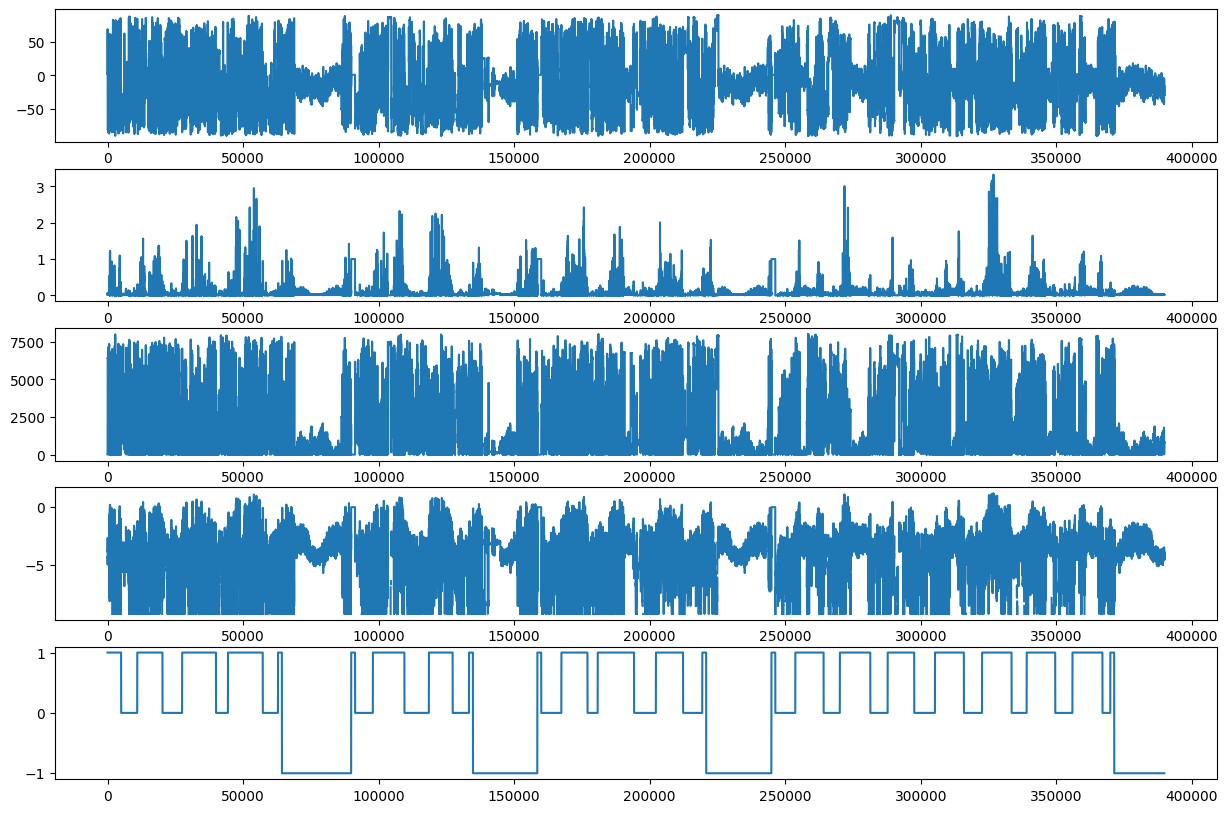

In [34]:


plt.figure(figsize=(15,10))

plt.subplot(5,1,1)
plt.plot(first_train['anglez'])
plt.subplot(5,1,2)
plt.plot(first_train['enmo'])
plt.subplot(5,1,3)
plt.plot(first_train['anglez']**2)
plt.subplot(5,1,4)
plt.plot(np.log(first_train['enmo'])+1e-7)
plt.subplot(5,1,5)
plt.plot(first_train['target'])
plt.show()

In [ ]:
a = np.clin(np.tan(df_train["enmno"]))